# Community detection
Perform Louvain community detection on different resolutions

In [2]:
%matplotlib inline
import pandas as pd
import os
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import community
import json

In [4]:
filepath = '/media/sf_VBox_Shared/CaseLaw/2018-01-29-lido/derived/subnetwork/article/no_phr/'
with open(os.path.join(filepath, 'network_gcc.json')) as f:
    nw = json.load(f)
graph = nx.readwrite.json_graph.node_link_graph({'nodes': nw['nodes'], 'links': nw['edges']}, 
                                                directed=True, multigraph=False)

In [5]:
graph.number_of_nodes(), graph.number_of_edges()

(338, 589)

In [6]:
resolution_range = np.arange(0.5, 2, 0.1)
nr_communities = np.zeros(len(resolution_range))
modularities = np.zeros(len(resolution_range))
com_df = pd.DataFrame()
for i in range(len(resolution_range)):
    partition = community.best_partition(graph.to_undirected(), resolution=resolution_range[i])
    nr_communities[i] = len(set(partition.values()))
    modularities[i] = community.modularity(partition, graph.to_undirected())
    com_df['com_{:.1f}'.format(resolution_range[i])] = pd.Series(partition)

/home/dafne/anaconda2/envs/caselaw/lib/python3.5/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


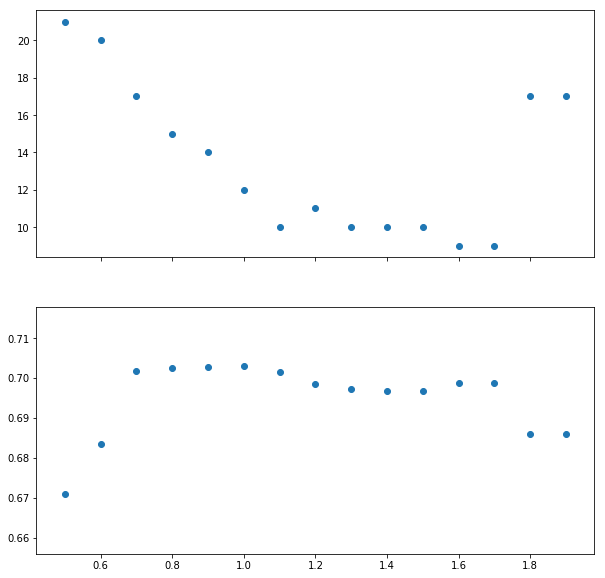

In [7]:
# What are the number of communities and modularity values
plt, axes = plt.subplots(2, sharex=True, figsize=(10,10))
axes[0].scatter(resolution_range, nr_communities)
axes[1].scatter(resolution_range, modularities)
plt.show()

In [9]:
com_df.nunique()

com_0.5    21
com_0.6    20
com_0.7    17
com_0.8    15
com_0.9    14
com_1.0    12
com_1.1    10
com_1.2    11
com_1.3    10
com_1.4    10
com_1.5    10
com_1.6     9
com_1.7     9
com_1.8    17
com_1.9    17
dtype: int64

## Save network with communities

In [10]:
selected_resolutions = [0.5, 0.7, 1.0, 1.3, 1.6]

In [11]:
for t in selected_resolutions:
    att = 'com_{:.1f}'.format(t)
    c = com_df[att.format(t)].to_dict()
    nx.set_node_attributes(graph, {n: int(c[n]) for n in c}, name=att)

In [12]:
fp_out = '/media/sf_VBox_Shared/CaseLaw/2018-01-29-lido/derived/subnetwork/article/no_phr/communities/'

for t in selected_resolutions:
    nw_t = {'title': nw['title']+' resolution {:.1f}'.format(t),
           'edges': nw['edges'],
           'nodes': [n.copy() for n in nw['nodes']] }
    for n in nw_t['nodes']:
        n['community'] = str(com_df.loc[n['id'],'com_{:.1f}'.format(t)])
    with open(os.path.join(fp_out, 'network_modularity_{:.1f}.json'.format(t)), 'w') as f:
        json.dump(nw_t, f, indent=True)

In [13]:
arts = nx.get_node_attributes(graph, 'articles')
nx.set_node_attributes(graph, {k: ' '.join(arts[k]) for k in arts}, 'articles')

In [14]:
nx.write_gexf(graph, os.path.join(fp_out, 'network_modularity.gexf'))